In [1]:
%run ~/work/jupyter_notebooks/gene\ family\ distances/correlate_evolution.ipynb

%cd ~/work/clusterEvo/new_tests/eggNOG/duplications/

/nobackup1b/users/thiberio/clusterEvo/new_tests/eggNOG/duplications


In [2]:
import multiprocessing
import itertools
import pandas as pd
import plotly
from scipy.stats import pearsonr, mannwhitneyu
from scipy.spatial.distance import braycurtis
import igraph as ig
from Bio import SeqIO
import requests

In [3]:
duplicated_genes = pd.read_csv('duplicated_genes.tsv', sep='\t', index_col=0)

duplicated_genes.taxa    = duplicated_genes.taxa.map(   lambda cell: cell.strip('[]').split(', '))
duplicated_genes.members = duplicated_genes.members.map(lambda cell: cell.split(','))
duplicated_genes.head()

,group_id,num_proteins,num_taxa,members,taxa
1205,arCOG00001,153,74,"[1006006.Mcup_1382, 1041930.Mtc_1877, 1042877....","[1006006, 1041930, 1042877, 1042877, 1042877, ..."
1206,arCOG00002,188,116,"[1006006.Mcup_0863, 1006006.Mcup_1338, 1006006...","[1006006, 1006006, 1006006, 1041930, 1041930, ..."
1209,arCOG00006,96,61,"[1033806.HTIA_1123, 1070774.J07HN4v3_02383, 10...","[1033806, 1070774, 1071085, 1071085, 1114856, ..."
1213,arCOG00014,441,167,"[1006006.Mcup_0948, 1006006.Mcup_1506, 1006006...","[1006006, 1006006, 1006006, 1033806, 1033806, ..."
1215,arCOG00016,62,62,"[1006006.Mcup_1914, 1042877.GQS_09465, 1056495...","[1006006, 1042877, 1056495, 1104324, 1131266, ..."


In [4]:
eggNOG_trees = pd.read_csv('../2157_trees.tsv',
                           sep      ='\t',
                           header   =None,
                           usecols  =[1,2,3],
                           index_col=0,
                           names    =['group_id', 'fast', 'tree'])
eggNOG_trees = eggNOG_trees.reindex(index=duplicated_genes.group_id)

In [5]:
group_ids = []
trees     = []
for index, row in eggNOG_trees.iterrows():
    group_ids.append(index)
    trees.append(ete3.Tree(row.tree))

pool          = multiprocessing.Pool(processes = 10)
dist_matrices = pool.map(get_matrix_from_tree, trees)
pool.close()
pool.join()

In [6]:
def run_coevol(matrices):
    m1 = matrices[0].copy()
    m2 = matrices[1].copy()
    return(assess_coevolution(m1, m2, gene_sep='.')[1])

matrix1 = dist_matrices[0].copy()
matrix2 = dist_matrices[2].copy()
print(run_coevol((matrix1, matrix2)))

None


In [13]:
if not os.path.isfile('Rsquared_duplicated_genes.parquet'):
    pool   = multiprocessing.Pool(processes=20)
    odr_r2 = pool.map(run_coevol, itertools.combinations(dist_matrices, 2))
    pool.close()
    pool.join()

    group_pairs = []
    for pair in itertools.combinations(group_ids, 2):
        group_pairs.append(pair)

    group_pairs = np.array(group_pairs)
    
    odr_df = pd.DataFrame(columns=['group1', 'group2', 'Rsquared'],
                          data   =zip(group_pairs[:, 0],
                                      group_pairs[:, 1],
                                      odr_r2))
    odr_df.to_csv('Rsquared_duplicated_genes.tsv', sep='\t')
    odr_df.to_parquet('Rsquared_duplicated_genes.parquet', compression='gzip', engine='fastparquet')
else:
    odr_df = pd.read_parquet('Rsquared_duplicated_genes.parquet')

In [15]:
odr_df['group_pair'] = odr_df[['group1', 'group2']].agg(frozenset, axis=1)
odr_df.set_index('group_pair', inplace=True)

odr_df.head()

,group1,group2,Rsquared
group_pair,,,
"(arCOG00001, arCOG00002)",arCOG00001,arCOG00002,0.593271
"(arCOG00001, arCOG00006)",arCOG00001,arCOG00006,NaN
"(arCOG00014, arCOG00001)",arCOG00001,arCOG00014,0.630685
"(arCOG00016, arCOG00001)",arCOG00001,arCOG00016,0.836091
"(arCOG00017, arCOG00001)",arCOG00001,arCOG00017,0.670219


In [17]:
def get_braycurtis(pair):
    (index1, row1), (index2, row2) = pair

    taxa1 = [taxon.split('.')[0] for taxon in row1.members]
    taxa2 = [taxon.split('.')[0] for taxon in row2.members]

    freq1 = Counter(taxa1)
    freq2 = Counter(taxa2)

    freq1_input = []
    freq2_input = []
    for taxon in set(taxa1).union(taxa2):
        if taxon in freq1:
            freq1_input.append(freq1[taxon])
        else:
            freq1_input.append(0)
        if taxon in freq2:
            freq2_input.append(freq2[taxon])
        else:
            freq2_input.append(0)    
            
    return(row1.group_id, 
           row2.group_id, 
           1 - braycurtis(freq1_input, freq2_input))

if not os.path.isfile('braycurtis_duplicated_genes.parquet'):
    pool               = multiprocessing.Pool(processes=10)
    braycurtis_indices = pool.map(get_braycurtis, 
                                  itertools.combinations(duplicated_genes.iterrows(), 2))
    pool.close()
    pool.join()

    braycurtis_df = pd.DataFrame(columns=['group1', 'group2', 'braycurtis'],
                                 data   =braycurtis_indices)
    braycurtis_df.to_parquet('braycurtis_duplicated_genes.parquet', compression='gzip', engine='fastparquet')
    braycurtis_df.to_csv(    'braycurtis_duplicated_genes.tsv', sep='\t')
else:
    braycurtis_df = pd.read_parquet('braycurtis_duplicated_genes.parquet')

In [18]:
braycurtis_df['group_pair'] = braycurtis_df[['group1', 'group2']].agg(frozenset, axis=1)
braycurtis_df.set_index('group_pair', inplace=True)
braycurtis_df.head()

,group1,group2,braycurtis
group_pair,,,
"(arCOG00001, arCOG00002)",arCOG00001,arCOG00002,0.539589
"(arCOG00001, arCOG00006)",arCOG00001,arCOG00006,0.016064
"(arCOG00014, arCOG00001)",arCOG00001,arCOG00014,0.404040
"(arCOG00016, arCOG00001)",arCOG00001,arCOG00016,0.493023
"(arCOG00017, arCOG00001)",arCOG00001,arCOG00017,0.534884


In [19]:
odr_df = odr_df.join(braycurtis_df.braycurtis)
odr_df['coevol_metric'] = odr_df.Rsquared * (odr_df.braycurtis**2)

odr_df.dropna(inplace=True)
odr_df.head()

,group1,group2,Rsquared,braycurtis,coevol_metric
group_pair,,,,,
"(arCOG00001, arCOG00002)",arCOG00001,arCOG00002,0.593271,0.539589,0.172735
"(arCOG00014, arCOG00001)",arCOG00001,arCOG00014,0.630685,0.404040,0.102959
"(arCOG00016, arCOG00001)",arCOG00001,arCOG00016,0.836091,0.493023,0.203230
"(arCOG00017, arCOG00001)",arCOG00001,arCOG00017,0.670219,0.534884,0.191750
"(arCOG00018, arCOG00001)",arCOG00001,arCOG00018,0.729820,0.419540,0.128459


In [20]:
data_columns = ['Rsquared', 'coevol_metric', 'braycurtis']

In [21]:
string = pd.read_parquet('duplicated_genes-string.parquet')

string['group_pair'] = string[['group1', 'group2']].agg(frozenset, axis=1)
string.drop_duplicates(subset='group_pair', inplace=True)

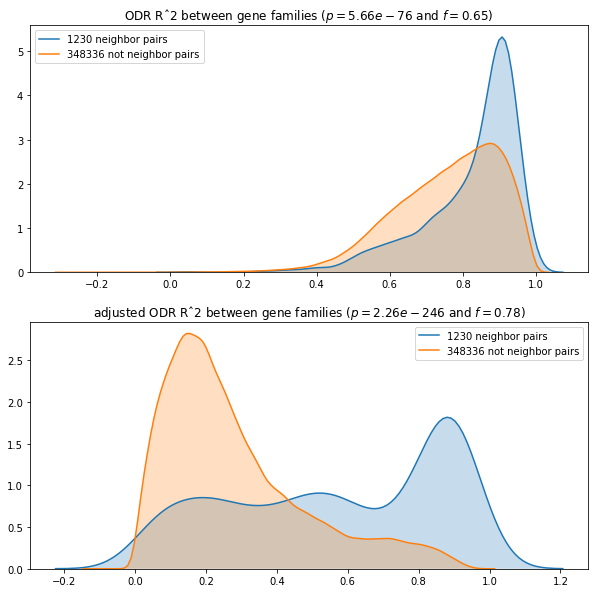

In [49]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
for ax, column in zip(axs, data_columns):
    
    neighors     = string.query('neighborhood >= 700')
    not_neighors = string.query('neighborhood <= 200')

    neighors_odr     = odr_df.query('group_pair in @neighors.group_pair'    )[column].values
    not_neighors_odr = odr_df.query('group_pair in @not_neighors.group_pair')[column].values

    hypothesis = mannwhitneyu(not_neighors_odr,
                              neighors_odr)
    effect_size = cles(not_neighors_odr, neighors_odr)

    sns.kdeplot(neighors_odr, shade=True,     label=f'{len(neighors_odr)} neighbor pairs',     ax=ax)
    sns.kdeplot(not_neighors_odr, shade=True, label=f'{len(not_neighors_odr)} not neighbor pairs', ax=ax)

    if column == 'Rsquared':
        ax.set_title(f'ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2e}$ and $f={effect_size:.2f}$)');
    else:
        ax.set_title(f'adjusted ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2e}$ and $f={effect_size:.2f}$)');

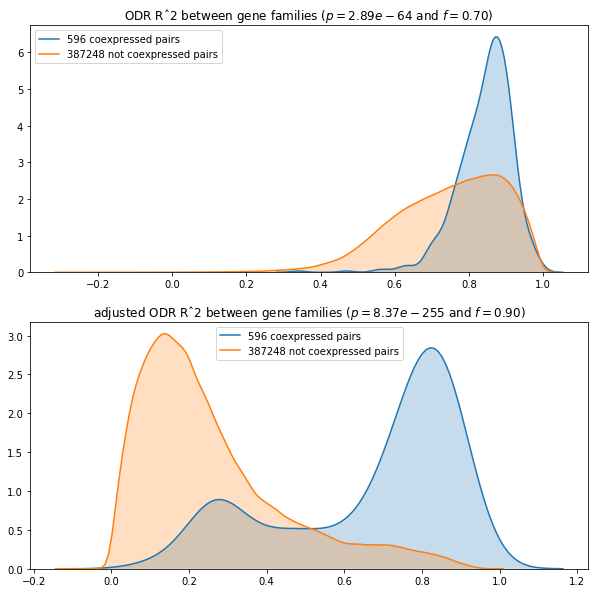

In [50]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
for ax, column in zip(axs, data_columns):
    
    coexpressed     = string.query('coexpression >= 700')
    not_coexpressed = string.query('coexpression <= 200')

    coexpressed_odr     = odr_df.query('group_pair in @coexpressed.group_pair'    )[column].values
    not_coexpressed_odr = odr_df.query('group_pair in @not_coexpressed.group_pair')[column].values

    hypothesis = mannwhitneyu(not_coexpressed_odr,
                              coexpressed_odr)
    effect_size = cles(not_coexpressed_odr, coexpressed_odr)

    sns.kdeplot(coexpressed_odr, shade=True,     label=f'{len(coexpressed_odr)} coexpressed pairs', ax=ax)
    sns.kdeplot(not_coexpressed_odr, shade=True, label=f'{len(not_coexpressed_odr)} not coexpressed pairs', ax=ax)

    if column == 'Rsquared':
        ax.set_title(f'ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2e}$ and $f={effect_size:.2f}$)');
    else:
        ax.set_title(f'adjusted ODR Rˆ2 between gene families ($p={hypothesis.pvalue:.2e}$ and $f={effect_size:.2f}$)');